Terrain data shape: (731, 1405)
Min elevation: -96.73 meters
Max elevation: 1544.94 meters


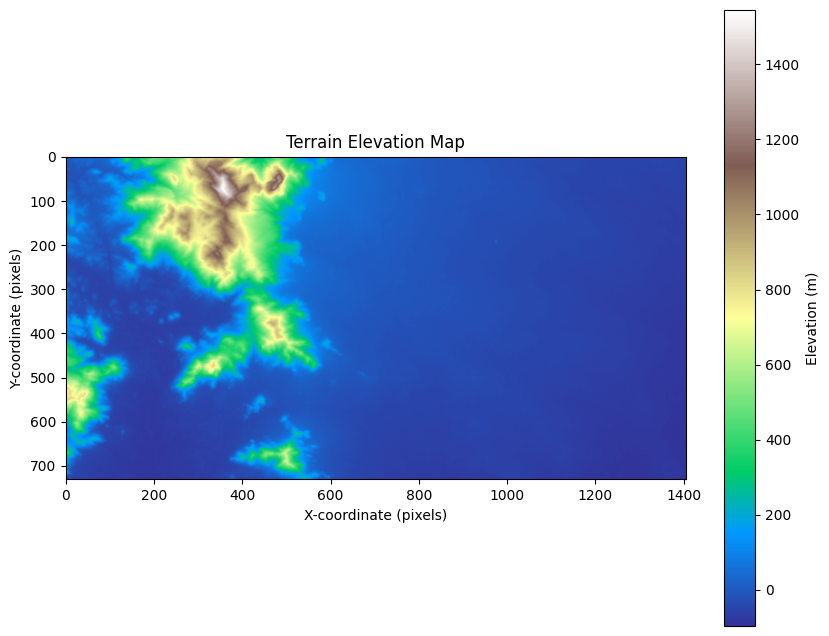

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Note the '..' to go up one directory from 'notebooks' to the main 'ATLAS' folder
terrain_file_path = '../data/terrain.tif'

with rasterio.open(terrain_file_path) as dataset:
    # Read the elevation data from the first band
    elevation = dataset.read(1)
    
    # Rasterio masks out empty data with very low numbers. Let's set them to NaN.
    elevation[elevation < -1000] = np.nan
    
    print(f"Terrain data shape: {elevation.shape}")
    print(f"Min elevation: {np.nanmin(elevation):.2f} meters")
    print(f"Max elevation: {np.nanmax(elevation):.2f} meters")
    
    # Plot the terrain data
    plt.figure(figsize=(10, 8))
    im = plt.imshow(elevation, cmap='terrain')
    plt.colorbar(im, label='Elevation (m)')
    plt.title('Terrain Elevation Map')
    plt.xlabel('X-coordinate (pixels)')
    plt.ylabel('Y-coordinate (pixels)')
    plt.show()

In [7]:
import pandas as pd
import numpy as np

def parse_wind_data(file_path):
    """
    Custom parser for GWA (Generalized Wind Atlas) .lib/.gwc files.
    This function extracts the wind rose and the mean wind speed for a specific
    height (100m) and roughness length (first one in the list).
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # --- Parse Metadata ---
    # The line '5 6 12' contains the dimensions
    dims = [int(d) for d in lines[1].strip().split()]
    num_roughnesses, num_heights, num_sectors = dims[0], dims[1], dims[2]
    
    # The line with heights: e.g., '10.0 50.0 100.0 150.0 200.0 250.0'
    heights = [float(h) for h in lines[3].strip().split()]
    
    # --- Find Target Data Indices ---
    # We want data for 100m height. Let's find its index.
    try:
        # Common hub height for modern turbines
        target_height = 100.0
        height_index = heights.index(target_height)
    except ValueError:
        # If 100m is not available, fall back to the highest available one
        target_height = heights[-1]
        height_index = len(heights) - 1
        print(f"Warning: 100m height not found. Using highest available: {target_height}m")
        
    # We will use the first roughness length (index 0)
    roughness_index = 0

    # --- Extract Data ---
    # Line 5 (index 4) contains the wind frequencies for all 12 sectors
    frequencies = [float(x) for x in lines[4].strip().split()]
    
    # The data is in blocks. We need to calculate the correct line to read.
    # Data starts at line 6 (index 5).
    # Each height has blocks for Speed, A-param, k-param. Each block has num_roughnesses rows.
    block_size_per_height = num_roughnesses * 3 
    
    # Calculate the line index for the Mean Wind Speed data we want
    # Jump to the block for the target height, then to the first row of that block (which is speeds),
    # then to the row for our target roughness.
    start_of_data_lines = 5
    speed_line_index = start_of_data_lines + (height_index * num_roughnesses) + roughness_index

    mean_speeds = [float(s) for s in lines[speed_line_index].strip().split()]
    
    # --- Create DataFrame ---
    wind_df = pd.DataFrame({
        'Sector': np.arange(1, num_sectors + 1),
        'Direction': np.arange(0, 360, 30), # 0=N, 30=NNE, etc.
        'Frequency': frequencies,
        'Mean_Wind_Speed_100m': mean_speeds
    })
    
    return wind_df

# --- Main execution ---
wind_file_path = '../data/wind_data.lib'
try:
    wind_df = parse_wind_data(wind_file_path)
    print("Wind data parsed successfully for 100m height!")
    print(wind_df)
except Exception as e:
    print(f"A critical error occurred during custom parsing: {e}")

Wind data parsed successfully for 100m height!
    Sector  Direction  Frequency  Mean_Wind_Speed_100m
0        1          0      15.54                 13.91
1        2         30      13.77                 10.90
2        3         60       4.72                  8.59
3        4         90       1.07                  3.86
4        5        120       0.52                  2.43
5        6        150       0.60                  2.91
6        7        180       0.94                  3.53
7        8        210       1.07                  4.24
8        9        240       3.15                 10.01
9       10        270      32.71                 23.52
10      11        300      20.45                 22.10
11      12        330       5.46                 15.88
